In [1]:
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import spikeinterface as si
import xarray as xr
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from aind_ephys_utils import align 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb, load_data
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import build_time_window_domain, \
                            build_spike_histogram, \
                            build_spike_histogram_overlap, \
                            fitSpikeModelP, \
                            fitSpikeModelG
import pandas as pd
import pickle
import scipy.stats as stats
%matplotlib inline
%matplotlib widget

In [2]:
session = 'behavior_751004_2024-12-20_13-26-11'
model_name = 'stan_qLearning_5params'
session_dir = session_dirs(session, model_name = model_name)
data_type = 'curated'
curate_time = True

In [3]:
# load behavior data
session_df = makeSessionDF(session, model_name = model_name)
tblTrials = get_session_tbl(session)

In [12]:
def convert_values(value):
    if isinstance(value, str):
        try:
            # Convert NumPy-like array strings into proper lists
            if "nan" in value:
                list_array = json.loads(value.replace("nan", "null"))
                return np.array(list_array)
            elif "[" in value and "]" in value and "," in value:
                string_list = value.replace("nan", "np.nan")
                return np.array(ast.literal_eval(string_list))
            elif "[" in value and "]" in value and "," not in value:
                # return np.array(ast.literal_eval(value.replace(" ", ",")))
                return np.fromstring(value.strip("[]"), sep=" ")
            else:
                return ast.literal_eval(value)  # Convert regular lists
        except (ValueError, SyntaxError):
            return value  # If conversion fails, return original string
    return value  # Return value as-is if not a string
    
def load_drift(session, unit_id, data_type='curated'):
    session_dir = session_dirs(session)
    drift_file = os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_drift_tbl.csv')
    opto_drift_tbl = pd.read_csv(drift_file)    
    opto_drift_tbl.reset_index(drop=True, inplace=True)
    if unit_id==None:
        return opto_drift_tbl
    else:
        if unit_id in opto_drift_tbl['unit_id'].values:
            unit_drift = opto_drift_tbl[opto_drift_tbl['unit_id'] == unit_id].iloc[0].to_dict()
            # Apply conversion
            converted_data = {key: convert_values(val) for key, val in unit_drift.items()}
            unit_drift = converted_data
            return unit_drift
        else:
            return None

def get_spike_matrix(spike_times, align_time, pre_event, post_event, binSize, stepSize):
    bin_times = np.arange(pre_event, post_event, stepSize) - 0.5*stepSize
    spike_matrix = np.zeros((len(align_time), len(bin_times)))
    for i, t in enumerate(align_time):
        for j, b in enumerate(bin_times):
            spike_matrix[i, j] = np.sum((spike_times >= t + b - 0.5*binSize) & (spike_times < t + b + 0.5*binSize))
    spike_matrix = spike_matrix / binSize
    return spike_matrix, bin_times

def plot_filled_sem(time, y_mat, color, ax, label):
    ax.plot(time, np.nanmean(y_mat, 0), c = color, label = label)
    sem = np.std(y_mat, axis = 0)/np.sqrt(np.shape(y_mat)[0])
    ax.fill_between(time, np.nanmean(y_mat, 0) - sem, np.nanmean(y_mat, 0) + sem, color = color, alpha = 0.25, edgecolor = None)
 
def plot_raster_rate(
    spike_times,
    currArray,
    slide_times,
    align_events, # sorted by certain value
    map_value,
    bins,
    labels,
    colormap,
    fig,
    subplot_spec,
    tb=-2,
    tf=3,
):
    n_colors = len(bins)-1
    color_list = [colormap(i / (n_colors - 1)) for i in range(n_colors)]

    """Plot raster and rate aligned to events"""
    nested_gs = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios= [3, 1], subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(nested_gs[0, 0])
    ax2 = fig.add_subplot(nested_gs[1, 0])

    # order events by values
    sort_ind = np.argsort(map_value)
    align_events = align_events[sort_ind]

    df = align.to_events(spike_times, align_events, (tb, tf), return_df=True)
    
    # vertical line at time 0
    ax1.axvline(x=0, c="r", ls="--", lw=1, zorder=1)

    # raster plot
    ax1.scatter(df.time, df.event_index, c="k", marker="|", s=1)

    # horizontal line for each type if discrete
    if len(np.unique(map_value)) <= 4:
        discrete_types = np.sort(np.unique(map_value))
    else:
        discrete_types = bins
    
    for val in discrete_types:
        level = np.sum(map_value <= val)
        ax1.axhline(y=level, c="k", ls="--", lw=1)

    ax1.set_title(' '.join(labels))
    ax1.set_xlim(tb, tf)
    ax1.set_ylabel('__'.join(labels))

    # rate plot by binned values

    for bin_ind in range(len(bins)-1): 
        currList = np.where((np.array(map_value)>=bins[bin_ind]) & (np.array(map_value)<bins[bin_ind + 1]))[0]
        if len(currList) > 0:
            M = currArray[currList, :]
            plot_filled_sem(slide_times, M, color_list[bin_ind], ax2, labels[bin_ind])

    ax2.legend()

    ax2.set_title("spike rate")
    ax2.set_xlim(tb, tf)
    ax2.set_xlabel("Time from alignment (s)")

    return fig, ax1, ax2

def plot_rate(
    currArray,
    slide_times, 
    map_value,
    bins,
    labels,
    colormap,
    fig,
    subplot_spec,
    tb,
    tf,
):
    n_colors = len(bins)-1
    color_list = [colormap(i / (n_colors - 1)) for i in range(n_colors)]

    """Plot rate aligned to events"""

    # rate plot by binned values
    ax = fig.add_subplot(subplot_spec)
    for bin_ind in range(len(bins)-1): 
        currList = np.where((np.array(map_value)>=bins[bin_ind]) & (np.array(map_value)<bins[bin_ind + 1]))[0]
        if len(currList) > 0:
            M = currArray[currList, :]
            plot_filled_sem(slide_times, M, color_list[bin_ind], ax, labels[bin_ind])

    ax.legend()

    ax.set_title("spike rate")
    ax.set_xlim(tb, tf)
    ax.set_xlabel("Time from alignment (s)")

    return fig, ax

def regression_rwd(spike_counts, outcome, trials_back = [0, 2], sub_selection = None):
    outcome_matrix = np.zeros((len(outcome), trials_back[1] - trials_back[0] + 1))
    for i in range(len(outcome)):
        for j in range(trials_back[0], trials_back[1] + 1):
            if i-j >=0:
                outcome_matrix[i, j] = outcome[i-j]
            else:
                outcome_matrix[i, j] = np.nan

    outcome_matrix = sm.add_constant(outcome_matrix)
    if sub_selection is not None:
        outcome_matrix = outcome_matrix[sub_selection, :]
        spike_counts = spike_counts[sub_selection]
    lm = sm.OLS(spike_counts, outcome_matrix, missing='drop').fit()
    return lm.params[1:], lm.pvalues[1:], lm.tvalues[1:], lm.conf_int(alpha=0.05)[1:] 
    


In [5]:
qm_dir = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
with open(qm_dir, 'r') as f:
    qm = json.load(f)

In [6]:
unit_tbl = get_unit_tbl(session, data_type)

In [7]:
pre_event=-1
post_event=3
binSize=0.2
stepSize=0.05
fs = 14
fsLegend = 8
formula = 'spikes ~ 1 + outcome + choice + Qchosen'
align_name = 'go_cue'

In [13]:
colors = ["blue", "white", "red"]
custom_cmap = LinearSegmentedColormap.from_list("blue_white_red", colors)
 
def plot_unit(unit_id, data_type = data_type, align_name=align_name):
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    qc_pass = unit_tbl.query('unit_id == @unit_id')['default_qc'].values[0]
    opto_pass = unit_tbl.query('unit_id == @unit_id')['opto_pass'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    if curate_time:
        if unit_drift is not None:
            if unit_drift['ephys_cut'][0] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            if unit_drift['ephys_cut'][1] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
                session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
    if len(session_df_curr) == 0:
        # return None and exit function
        print(f'No session data for unit {unit_id}')
        return None
    else:
        print(f'Plotting unit {unit_id}')      
        if align_name == 'go_cue':
            align_time = session_df_curr['go_cue_time'].values
        elif align_name == 'response':
            align_time = session_df_curr['choice_time'].values
        spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
                                                    pre_event=pre_event, post_event=post_event, 
                                                    binSize=binSize, stepSize=stepSize)
        spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                    pre_event=-2, post_event=2.5, 
                                                    binSize=0.5, stepSize=0.2)

        fig = plt.figure(figsize=(20, 10))
        gs = gridspec.GridSpec(2, 7, height_ratios=[3, 1], wspace=0.35, hspace=0.2)
        # plot session
        ax = fig.add_subplot(gs[0, 0]) 
        choice_history, reward_history, p_reward, autowater_offered, random_number, trial_time = get_history_from_nwb(session_df_curr)
        plot_foraging_session(  # noqa: C901
                        choice_history,
                        reward_history,
                        p_reward = p_reward,
                        autowater_offered = autowater_offered,
                        ax = ax,
                        legend=False,
                        ax_lim=[0, len(session_df_curr)],
                        vertical=True,
                        ) 
        ax.set_ylim(0, len(session_df_curr))
        # from start to end
        ax = fig.add_subplot(gs[0, 1])  
        df = align.to_events(spike_times_curr, align_time, (pre_event, post_event), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1, zorder = 2)
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('Trial number')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))


        # waveform
        ax = fig.add_subplot(gs[1, 0])  
        waveform = unit_tbl.query('unit_id == @unit_id')['waveform_mean'].values[0]
        peakChannel = np.argmin(np.min(waveform, axis=0))
        peakWaveform = waveform[:,peakChannel]
        peakSD = unit_tbl.query('unit_id == @unit_id')['waveform_mean'].values[0][:,peakChannel]
        timeWF = np.array(range(len(peakWaveform)))-90
        ax.plot(timeWF, peakWaveform, color = 'k')
        ax.fill_between(timeWF, peakWaveform - peakSD/np.sqrt(499), peakWaveform + peakSD/np.sqrt(499), color = 'k', alpha = 0.1)
        ax.axhline(y=0, color = 'r', ls = '--')
        ax.set_xlabel('Time (ms)', fontsize = fs)
        ax.set_ylabel(r'$\mu$-Plot')

        # reward and no reward
        outcome_int = [int(item) for item in session_df_curr['outcome'].tolist()]
        bins = [-1, 0.5, 1.5]
        labels = ['no reward', 'reward']
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                        spike_matrix, 
                                        slide_times,
                                        align_time, 
                                        outcome_int, # sorted by certain value
                                        bins,
                                        labels, 
                                        custom_cmap,
                                        fig,
                                        gs[0, 2],
                                        tb=pre_event,
                                        tf=post_event,
                                        )
        ax1.set_title('Reward vs No Reward', fontsize = fs+2)

        # left and right
        side_int = [int(item) for item in session_df_curr['choice'].tolist()]
        bins = [-1.5, 0.5, 1.5]
        labels = ['left', 'right']
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                        spike_matrix,
                                        slide_times, 
                                        align_time, 
                                        side_int, # sorted by certain value
                                        bins,
                                        labels,
                                        custom_cmap,
                                        fig,
                                        gs[0, 3],
                                        tb=pre_event,
                                        tf=post_event,
                                        )
        ax1.set_title('Right vs Left', fontsize = fs+2)

        # rpe
        target_var = 'pe'
        bin_counts = 4
        bins = np.quantile(session_df_curr[target_var].values, np.linspace(0, 1, bin_counts+1))
        # bins = [-1.0001, -0.5, 0, 0.5, 1.0001]
        bins[0] = bins[0] - 0.0001
        bins[-1] = bins[-1] + 0.0001
        labels = ['1', '2', '3', '4']
        
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                        spike_matrix, 
                                        slide_times,
                                        align_time,  
                                        session_df_curr[target_var].values, # sorted by certain value
                                        bins,
                                        labels,
                                        custom_cmap,
                                        fig,
                                        gs[0, 4],
                                        tb=pre_event,
                                        tf=post_event,
                                        )
        # ax.set_yticks([])
        # ax.set_ylabel(label, fontsize = fs)
        ax1.set_title(target_var, fontsize = fs+2)


        # Qchosen
        target_var = 'Qchosen'
        bin_counts = 4
        bins = np.quantile(session_df_curr[target_var].values, np.linspace(0, 1, bin_counts+1))
        # bins = [-1.0001, -0.5, 0, 0.5, 1.0001]
        bins[0] = bins[0] - 0.0001
        bins[-1] = bins[-1] + 0.0001
        labels = ['1', '2', '3', '4']
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr,
                                        spike_matrix, 
                                        slide_times,
                                        align_time, 
                                        session_df_curr[target_var].values, # sorted by certain value
                                        bins,
                                        labels,
                                        custom_cmap,
                                        fig,
                                        gs[0, 5],
                                        tb=pre_event,
                                        tf=post_event,
                                        )
        ax1.set_title(target_var, fontsize = fs+2)

        # stay vs switch
        target_var = 'svs'
        # bins = np.quantile(session_df_curr[target_var].values, np.linspace(0, 1, bin_counts+1))
        bins = [-1.0001, 0.5, 1.0001]
        labels = ['stay', 'switch']
        # ax = fig.add_subplot(gs[1, 1])
        fig, ax = plot_rate(
                            spike_matrix,
                            slide_times, 
                            session_df_curr[target_var].values,
                            bins,
                            labels,
                            custom_cmap,
                            fig,
                            gs[1, 1],
                            tb=pre_event,
                            tf=post_event,
                            )

        ax.set_yticks([])
        ax.set_title(target_var, fontsize = fs+2)

        # right rwd vs no rwd
        target_var = 'outcome'
        spike_matrix_curr = spike_matrix[session_df_curr['choice'].values == 1, :]
        focus_var = session_df_curr[session_df_curr['choice'].values == 1][target_var].values
        bins = [-1.0001, 0.5, 1.0001]
        labels = ['no rwd', 'rwd']
        fig, ax = plot_rate(
                            spike_matrix_curr,
                            slide_times,
                            focus_var,
                            bins,
                            labels,
                            custom_cmap,
                            fig,
                            gs[1, 2],
                            tb=pre_event,
                            tf=post_event,
                            )
        ax.set_title('Right: rwd nrwd', fontsize = fs+2)

        # left rwd vs no rwd
        target_var = 'outcome'
        spike_matrix_curr = spike_matrix[session_df_curr['choice'].values == 0, :]
        focus_var = session_df_curr[session_df_curr['choice'].values == 0][target_var].values
        bins = [-1.0001, 0.5, 1.0001]
        labels = ['no rwd', 'rwd']
        fig, ax = plot_rate(
                            spike_matrix_curr,
                            slide_times,
                            focus_var,
                            bins,
                            labels,
                            custom_cmap,
                            fig,
                            gs[1, 3],
                            tb=pre_event,
                            tf=post_event,
                            )
        ax.set_title('Left: rwd nrwd', fontsize = fs+2)
        
        
        if len(session_df_curr) > 100 and np.sum((spike_times_curr>=session_df_curr['go_cue_time'].values[0]) & (spike_times_curr<=session_df_curr['go_cue_time'].values[-1]))/(session_df_curr['go_cue_time'].values[-1] - session_df_curr['go_cue_time'].values[0]) > 0.1:
            # rwd history
            # fr with regression with rwd history
            target_var = 'outcome'
            vector = session_df_curr[target_var].values
            align_time = session_df_curr['choice_time'].values
            _, events_id, _ = align.to_events(spike_times_curr, align_time, (0, 1.5), return_df=False) 
            spike_counts = [np.sum(events_id==curr_id) for curr_id in range(len(align_time))]
            spike_counts = stats.zscore(np.array(spike_counts))
            trials_back = [0, 2]
            coeffs, pvals, tvals, conf_int = regression_rwd(spike_counts, vector, trials_back = trials_back)

            ax = fig.add_subplot(gs[1, 4])
            ax.plot(range(trials_back[0], trials_back[1] + 1), coeffs, c = 'k', lw = 2)
            ax.fill_between(range(trials_back[0], trials_back[1] + 1), conf_int[:, 0], conf_int[:, 1], color = 'k', alpha = 0.25, edgecolor = None)
            ax.axhline(y=0, color = 'r', ls = '--')
            ax.scatter(np.array(range(trials_back[0], trials_back[1] + 1))[pvals<0.05], coeffs[pvals<0.05], c = 'r', s = 10, zorder = 2)
            ax.set_title('Spikes~rwd history', fontsize = fs+2)
            ax.set_xlabel('Trials back')

            # only on left trials
            trials_back = [0, 2]
            if np.sum(session_df_curr['choice'].values == 0) >= 40:
                coeffs, pvals, tvals, conf_int = regression_rwd(spike_counts, vector, trials_back = trials_back, sub_selection=session_df_curr['choice'].values == 0)
                ax = fig.add_subplot(gs[1, 5])
                ax.plot(range(trials_back[0], trials_back[1] + 1), coeffs, c = 'm', lw = 2, label = 'left')
                ax.fill_between(range(trials_back[0], trials_back[1] + 1), conf_int[:, 0], conf_int[:, 1], color = 'm', alpha = 0.25, edgecolor = None)
                ax.scatter(np.array(range(trials_back[0], trials_back[1] + 1))[pvals<0.05], coeffs[pvals<0.05], c = 'r', s = 10)
                ax.axhline(y=0, color = 'r', ls = '--')
                ax.set_title('Spikes~rwd hist L/R', fontsize = fs+2)
                ax.set_xlabel('Trials back')
                ax.legend()

            # only on right trials
            if np.sum(session_df_curr['choice'].values == 1) >= 40:
                coeffs, pvals, tvals, conf_int = regression_rwd(spike_counts, vector, trials_back = trials_back, sub_selection=session_df_curr['choice'].values == 1)
                ax.plot(range(trials_back[0], trials_back[1] + 1), coeffs, c = 'c', lw = 2, label = 'right')
                ax.fill_between(range(trials_back[0], trials_back[1] + 1), conf_int[:, 0], conf_int[:, 1], color = 'c', alpha = 0.25, edgecolor = None)
                ax.scatter(np.array(range(trials_back[0], trials_back[1] + 1))[pvals<0.05], coeffs[pvals<0.05], c = 'r', s = 10)
                ax.axhline(y=0, color = 'r', ls = '--')
                ax.set_title('Spikes~rwd hist L/R', fontsize = fs+2)
                ax.set_xlabel('Trials back')
                ax.legend()

            # plot regresssions
            gs = gridspec.GridSpec(3, 7, height_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
            ax = fig.add_subplot(gs[0,-1])
            regressors, TvCurrU, PvCurrU, EvCurrU = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
            TvCurrUSig = TvCurrU.copy()
            TvCurrUSig[PvCurrU>=0.05] = np.nan
            cmap = plt.get_cmap('viridis')
            colors = cmap(np.linspace(0, 1, len(regressors)))
            for regress in range(1, len(regressors)):
                ax.plot(slide_times_LM, TvCurrU[:, regress], lw = 2, color = colors[regress,], label = regressors[regress])
                ax.plot(slide_times_LM, TvCurrUSig[:, regress], lw = 4, color = colors[regress,])
            ax.legend(fontsize = fsLegend)
            ax.set_xlabel(f'Time from {align_name} (s)')
            ax.set_title('T-stats', fontsize = fs)

            ax = fig.add_subplot(gs[1,-1])
            for regress in range(1, len(regressors)):
                ax.plot(slide_times_LM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])

            plt.axhline(y = -np.log10(0.05), color='r', ls = '--')
            ax.legend(fontsize = fsLegend)
            ax.set_xlabel(f'Time from {align_name} (s)')
            ax.set_title('p-value', fontsize = fs)
            plt.suptitle(f'Unit{str(unit_id)} Aligned to {align_name} default qc: {qc_pass} maybe opto: {opto_pass}', fontsize = 20) 
        # plt.tight_layout()  
        return fig

Plotting unit 1


/opt/conda/lib/python3.10/site-packages/aind_dynamic_foraging_basic_analysis/plot/plot_foraging_session.py:508: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


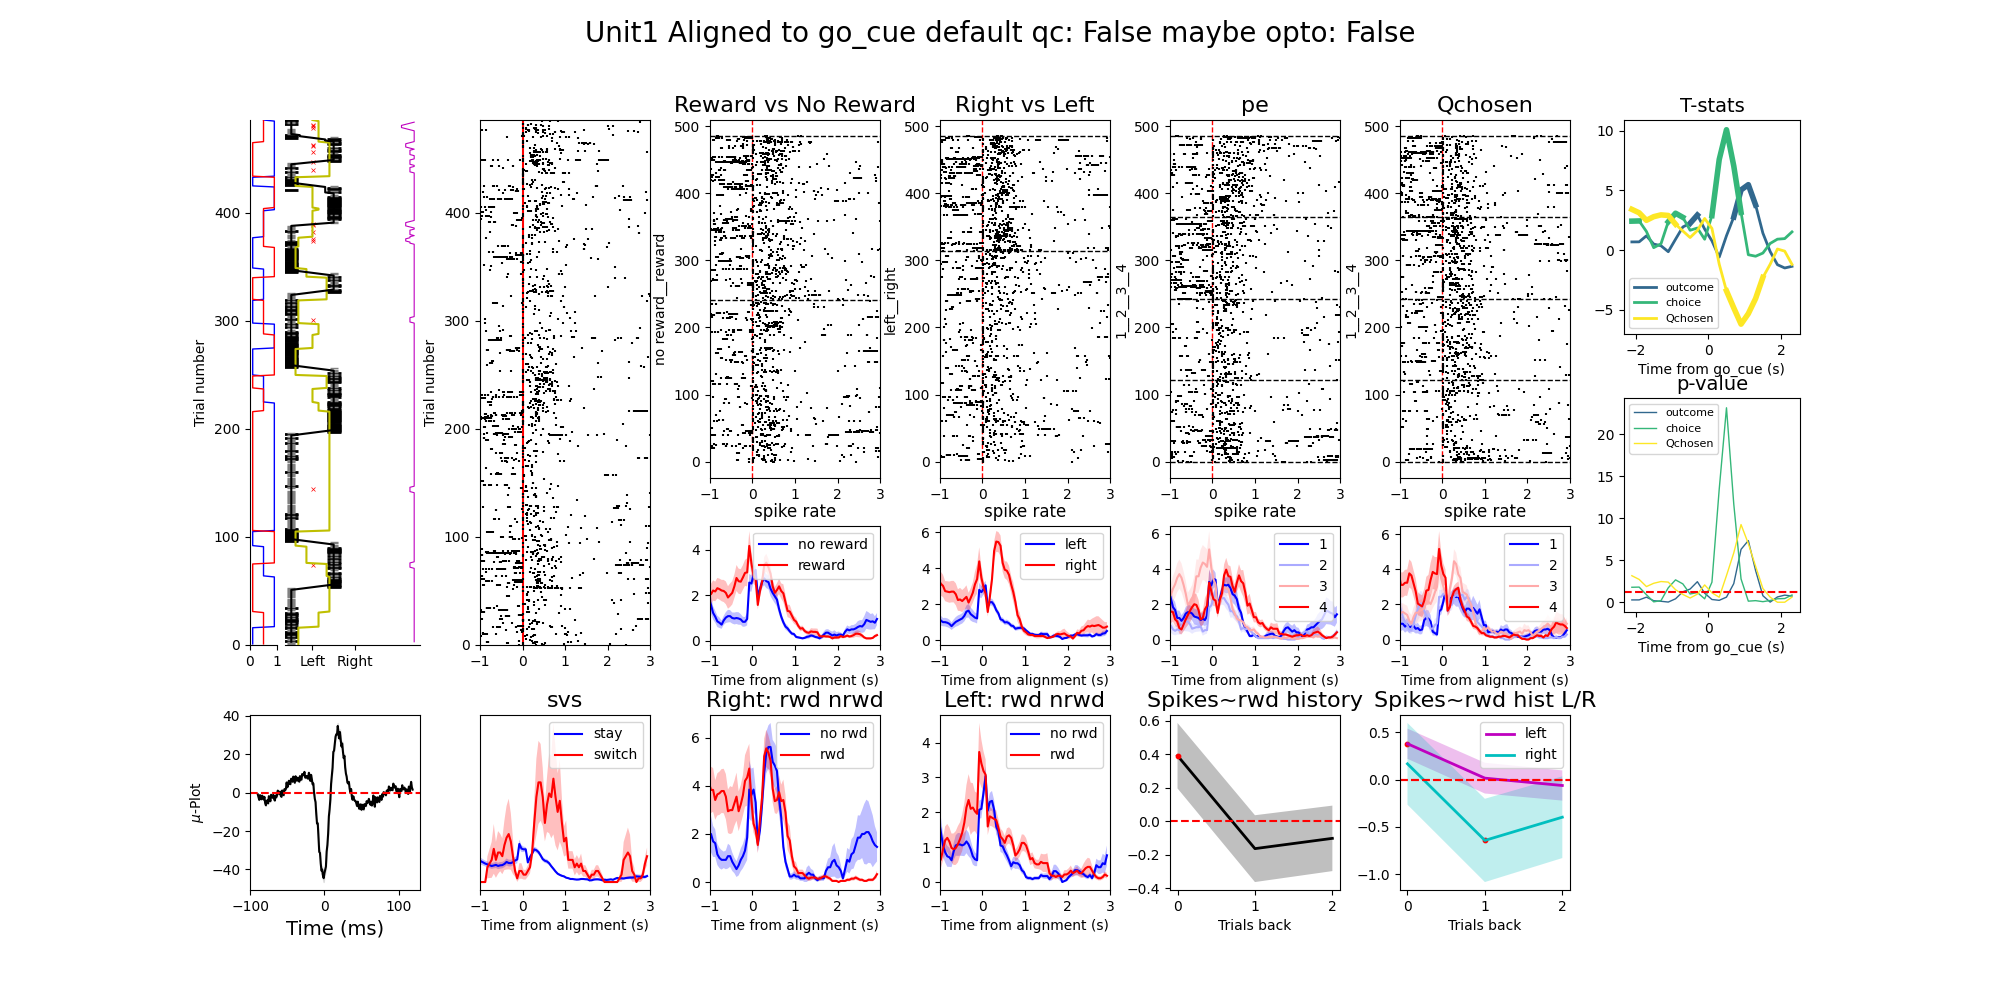

In [14]:
fig = plot_unit(1, data_type = data_type, align_name='go_cue') 

In [16]:
def process(unit_id):
    try:
        fig = plot_unit(unit_id, data_type = data_type, align_name='go_cue') 
        if fig is not None:
            fig.savefig(fname=os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'unit_{unit_id}_goCue.pdf'))
        plt.close(fig)
        # time.sleep(1)
        # plt.show()
    except:
        print(f'Unit {unit_id} failed to plot')

from joblib import Parallel, delayed

Parallel(n_jobs=10)(
    delayed(process)(unit_id)
    for unit_id in unit_tbl['unit_id'].values
)


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py", line 53, in run
    self._on_run()
  File "/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 432, in _on_run
    self.py_db.dispose_and_kill_all_pydevd_threads()
  File "/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2558, in dispose_and_kill_all_pydevd_threa

KeyboardInterrupt: 

In [17]:
pdf_dir = session_dir[f'ephys_fig_dir_{data_type}']
output_pdf = os.path.join(session_dirs(session)[f'ephys_dir_{data_type}'], f'{session}_unit_beh.pdf')
if os.path.exists(pdf_dir) and not os.path.exists(output_pdf):
    print(f'Combining {session}')
    combine_pdf_big(pdf_dir, output_pdf)